GAN 논문 : https://arxiv.org/pdf/1406.2661.pdf

아래는 논문에 게재된 예제입니다.

메모
- 무작위 잡음 벡터 Z는 균등분포 확률 신호이고 출력은 정규분포 확률 신호이다.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K

위에 임포트한 모듈 중에서 새로 보이는 것이 Lambda 입니다.

람다라는 이름이 의미하는 것 처럼 어떤 함수를 입력 데이터에 적용시켜서 Layer 객체를 만드는 역할을 합니다.
https://keras.io/layers/core/


아래는 책 3분 딥러닝에 나오는 GAN 모델에 대한 클래스의 코드인데, 바로 이해하기 어렵습니다.

처음 보는 함수나 기능들은 실제로 타이핑을 해보면서 이해해보겠습니다.

In [28]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)
        

위의 Data 클래스는 평균, 표준편차와 어떤 차원의 길이(ni_D)를 저장하고 n_batch 라는 다른 차원의 길이를 입력받으면 (n_batch, ni_D) 크기의 정규분포를 만드는 함수와,  같은 크기의 0에서 1사이의 균일 분포를 만드는 함수를 저장하고 있습니다.

- nh_D : 판별망의 은닉층 노드 수
- nh-G : 생성망의 은닉층 노드 수
- 논문에는 배치별로 판별망을 생성망보다 더 많이 학습하면 최적화에 도움이 된다고...


In [29]:
lr = 2e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)

def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam,
                        metrics=['accuracy'])

In [30]:
# GAN 모델링
def add_decorate(x):
    """
    m : 입력 데이터 x의 마지막 차원에 해당하는 시쿼스 자료의 평균을 구하고
        원래의 차원을 유지한다.
    d : 입력 데이터 x의 평균으로부터의 편차를 제곱한 값을 저장한다.
    
    Return
    ------
    x 와 d 를 연결한 배열을 리턴한다.
    x 의 마지막 차원의 길이가 두 배가 된다.
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)

def add_decorate_shape(input_shape):
    """입력된 길이가 2인 shape 정보를 담은 튜플의 두 번째 원소를 2배한 튜플을 리턴한다.
    """
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)
    
class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        """세 개의 차원에 대한 값을 입력 받아서 GAN 에 필요한 모델들을 만든다.
        """
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G
        
        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()
        
    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))
        
        model_compile(D)
        return D
    
    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D
        
        G = models.Sequential()
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))
        G.add(Conv1D(nh_G, 1, activation='relu'))
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))
        G.add(Conv1D(1, 1))
        G.add(Flatten())
        
        model_compile(G)
        return G
    
    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD
    
    def D_train_on_batch(self, Real, Gen):
        """실제 데이터 Real 과 가짜 데이터 Gen 에 대한 각각의 레이블은 1 과 0 이다.
           이 데이터셋으로 모델 D 를 훈련시킨다.
        """
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1]*Real.shape[0] + [0]*Gen.shape[0])
        D.train_on_batch(X, y)
        
    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1]*Z.shape[0])
        GD.train_on_batch(Z, y)
        
        

In [31]:


# Machine 구현하기
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25
        
        self.n_iter_D = 1
        self.n_iter_G = 5
        
        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)
        
        self.n_batch = n_batch
    
    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        
        # Real data
        Real = data.real_sample(n_batch)
        # Generated data
        Z = data.in_sample(n_batch)
        Gen = gan.G.predict(Z)
        
        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)
        
    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data fro data generation
        Z = data.in_sample(n_batch)
        
        gan.D.trainable = False
        gan.GD_train_on_batch(Z)
        
    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()

        for it in range(self.n_iter_G):
            self.train_GD()
            
    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()
            
    def test(self, n_test):
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z
    
    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)
        
    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)
        
    def run_epochs(self, epochs, n_test):
        self.train(epochs)
        self.test_and_show(n_test)
        
    def run(self, n_repeat=200, n_show=200, n_test=100):
        for i in range(n_repeat):
            print('Stage {}, Epoch: {}'.format(i, i*n_show))
            self.run_epochs(n_show, n_test)
            plt.show()
            
    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return np.mean(d), np.std(d)
        print('Mean and Std of Real: ', stat(Real))
        print('Mean and Std of Gen:  ', stat(Gen))
        

In [32]:
def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)

Stage 0, Epoch: 0
Mean and Std of Real:  (4.0080427616223089, 1.25335896622161)
Mean and Std of Gen:   (0.58979309, 0.40614098)


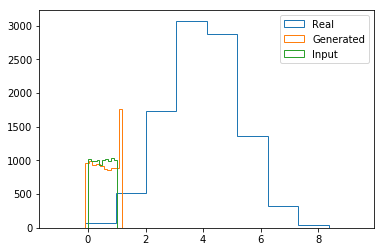

Stage 1, Epoch: 200
Mean and Std of Real:  (4.018515638199645, 1.2549533766212824)
Mean and Std of Gen:   (3.0762026, 1.1120672)


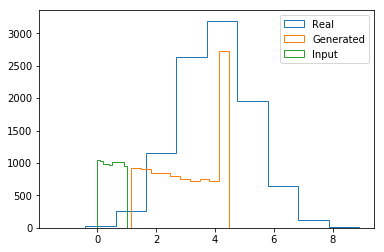

Stage 2, Epoch: 400
Mean and Std of Real:  (4.0245913401936573, 1.2531093957258128)
Mean and Std of Gen:   (4.8037772, 1.1165028)


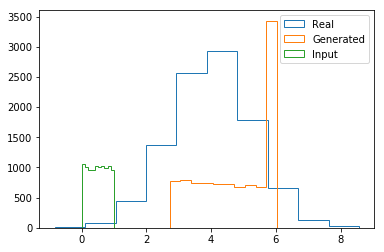

Stage 3, Epoch: 600
Mean and Std of Real:  (3.9975912700665606, 1.2511447254540573)
Mean and Std of Gen:   (3.8753016, 1.6978101)


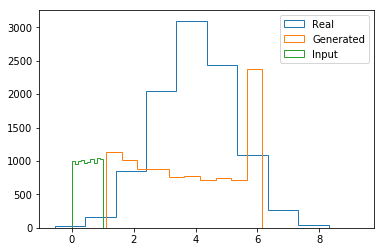

Stage 4, Epoch: 800
Mean and Std of Real:  (3.9983124887412016, 1.2498604463924918)
Mean and Std of Gen:   (4.2630329, 1.1181459)


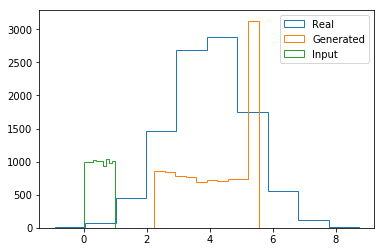

Stage 5, Epoch: 1000
Mean and Std of Real:  (3.9986631790398781, 1.2457029803567454)
Mean and Std of Gen:   (3.0647805, 1.331918)


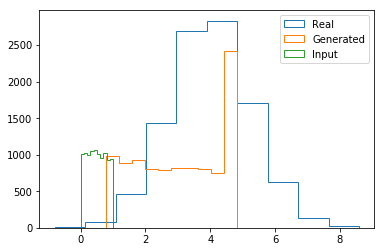

Stage 6, Epoch: 1200
Mean and Std of Real:  (4.0166651797414783, 1.2550374077804078)
Mean and Std of Gen:   (3.7998726, 1.1469717)


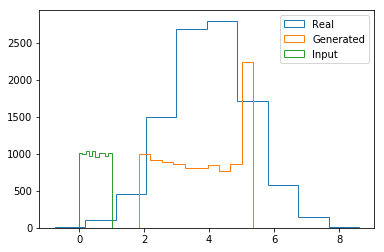

Stage 7, Epoch: 1400
Mean and Std of Real:  (3.9806240838440217, 1.2628809841419293)
Mean and Std of Gen:   (3.4387753, 1.1826705)


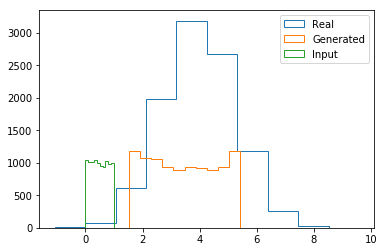

Stage 8, Epoch: 1600
Mean and Std of Real:  (4.010095142128332, 1.2574351547631768)
Mean and Std of Gen:   (4.0227947, 1.2423365)


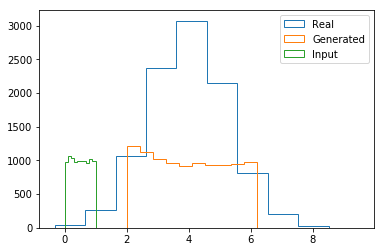

Stage 9, Epoch: 1800
Mean and Std of Real:  (3.9970653456509493, 1.247685391645768)
Mean and Std of Gen:   (4.1677666, 1.0209326)


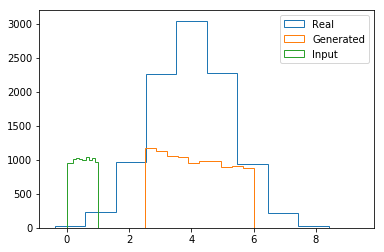

Stage 10, Epoch: 2000
Mean and Std of Real:  (3.990762015401061, 1.2484469961728681)
Mean and Std of Gen:   (3.6693411, 1.1961724)


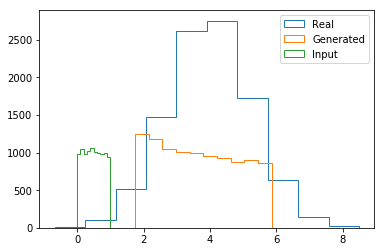

Stage 11, Epoch: 2200
Mean and Std of Real:  (3.995147930535309, 1.2415035580708882)
Mean and Std of Gen:   (3.8720763, 1.2550807)


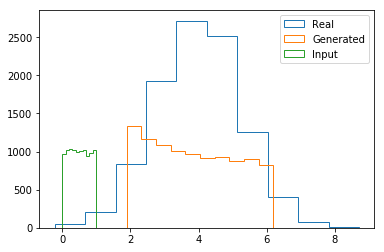

Stage 12, Epoch: 2400
Mean and Std of Real:  (4.0212296131547918, 1.2540201932254091)
Mean and Std of Gen:   (3.5832906, 1.2835132)


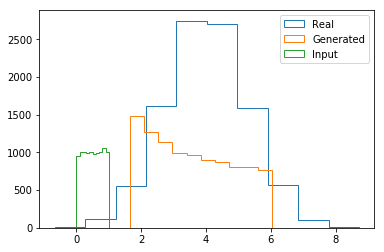

Stage 13, Epoch: 2600
Mean and Std of Real:  (3.9796674576486062, 1.2429123072760322)
Mean and Std of Gen:   (3.5818439, 1.0888158)


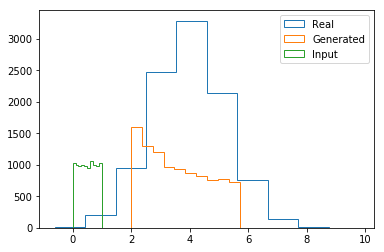

Stage 14, Epoch: 2800
Mean and Std of Real:  (4.0152872673043936, 1.2552694968889304)
Mean and Std of Gen:   (3.7970078, 1.0723606)


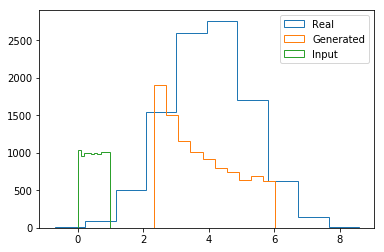

Stage 15, Epoch: 3000
Mean and Std of Real:  (3.9987242605134825, 1.2432271532614227)
Mean and Std of Gen:   (3.6021886, 1.1412081)


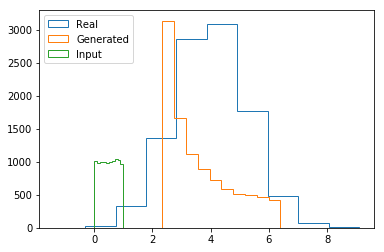

Stage 16, Epoch: 3200
Mean and Std of Real:  (4.0309487302209961, 1.2691524391618667)
Mean and Std of Gen:   (4.3919301, 1.2253118)


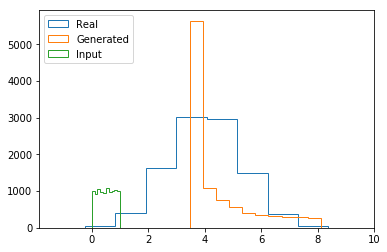

Stage 17, Epoch: 3400
Mean and Std of Real:  (4.0028610445111994, 1.2493730791552395)
Mean and Std of Gen:   (5.4033914, 1.4359393)


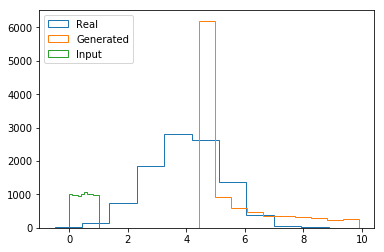

Stage 18, Epoch: 3600
Mean and Std of Real:  (4.0091898422022307, 1.2539547615566389)
Mean and Std of Gen:   (6.5584579, 1.4926478)


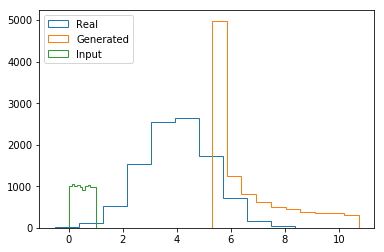

Stage 19, Epoch: 3800
Mean and Std of Real:  (3.9989807056633215, 1.2517318221888061)
Mean and Std of Gen:   (6.441978, 1.7110466)


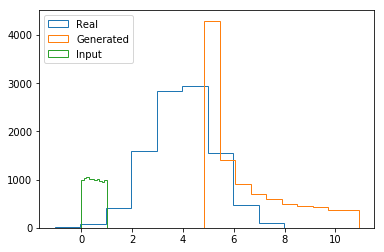

Stage 20, Epoch: 4000
Mean and Std of Real:  (3.9874341997937948, 1.2430898893581801)
Mean and Std of Gen:   (5.5047274, 1.5716163)


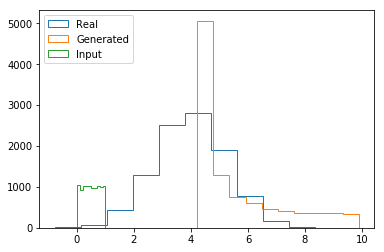

Stage 21, Epoch: 4200
Mean and Std of Real:  (3.9920230014879365, 1.2540312767254758)
Mean and Std of Gen:   (5.0622396, 1.4357636)


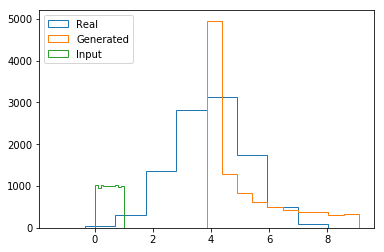

Stage 22, Epoch: 4400
Mean and Std of Real:  (3.9973379216096836, 1.2503790994014747)
Mean and Std of Gen:   (5.0002203, 1.3315469)


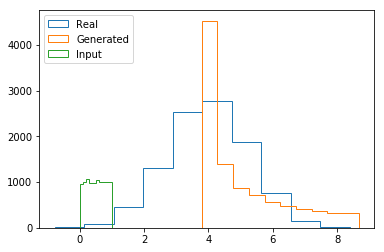

Stage 23, Epoch: 4600
Mean and Std of Real:  (3.9883819696881431, 1.2534093791201051)
Mean and Std of Gen:   (4.5934463, 1.4032912)


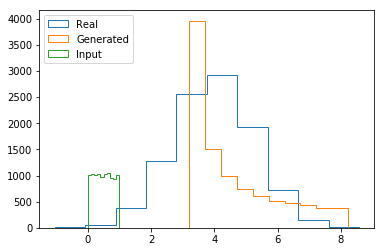

Stage 24, Epoch: 4800
Mean and Std of Real:  (3.9940109326416038, 1.2564548958178854)
Mean and Std of Gen:   (3.9291186, 1.2919953)


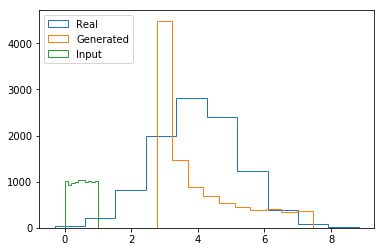

Stage 25, Epoch: 5000
Mean and Std of Real:  (3.9877866329925258, 1.246418309543919)
Mean and Std of Gen:   (3.9840062, 1.281081)


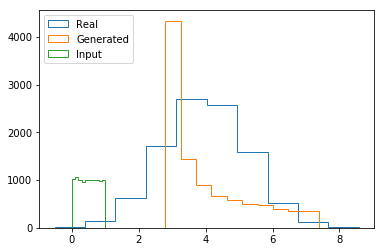

Stage 26, Epoch: 5200
Mean and Std of Real:  (4.012980684175071, 1.2576344462323208)
Mean and Std of Gen:   (4.0979137, 1.1660727)


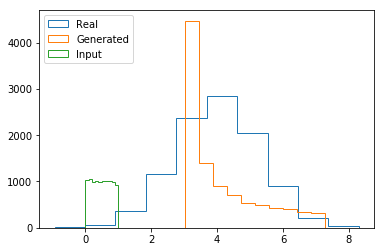

Stage 27, Epoch: 5400
Mean and Std of Real:  (4.0161954870869652, 1.2509045084827015)
Mean and Std of Gen:   (4.0441294, 1.165043)


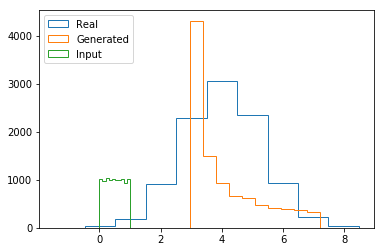

Stage 28, Epoch: 5600
Mean and Std of Real:  (3.9797191211839511, 1.2458679273205371)
Mean and Std of Gen:   (4.2668152, 1.2720819)


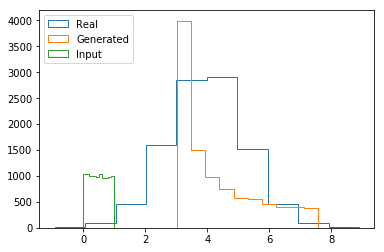

Stage 29, Epoch: 5800
Mean and Std of Real:  (4.0085809259148428, 1.2310552088475961)
Mean and Std of Gen:   (3.8270938, 1.324683)


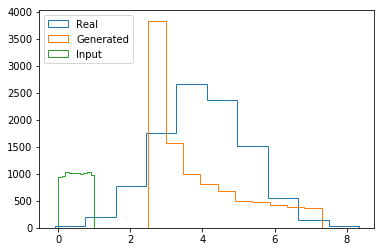

Stage 30, Epoch: 6000
Mean and Std of Real:  (4.0039336773183463, 1.2509362728724465)
Mean and Std of Gen:   (3.6761913, 1.4060686)


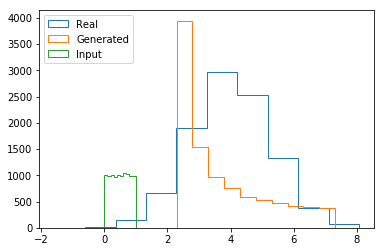

Stage 31, Epoch: 6200
Mean and Std of Real:  (4.0033124963597775, 1.2500625915300525)
Mean and Std of Gen:   (3.9640703, 1.4284418)


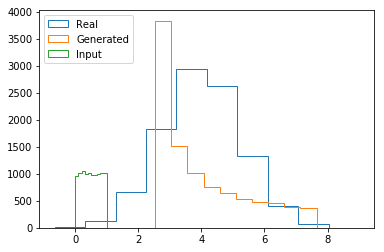

Stage 32, Epoch: 6400
Mean and Std of Real:  (4.006185027387378, 1.2446960751231639)
Mean and Std of Gen:   (4.1194048, 1.2091273)


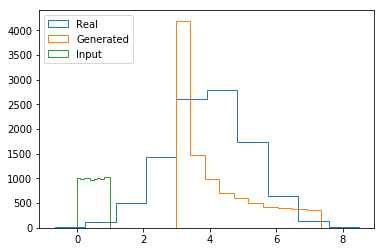

Stage 33, Epoch: 6600
Mean and Std of Real:  (3.9876206680755537, 1.2517490888710714)
Mean and Std of Gen:   (3.9648535, 1.2093277)


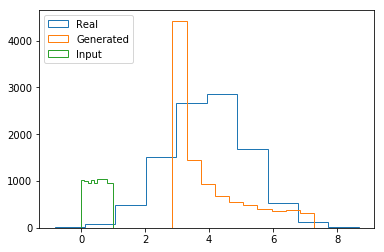

Stage 34, Epoch: 6800
Mean and Std of Real:  (3.9744688549781384, 1.2526395400333041)
Mean and Std of Gen:   (4.1185713, 1.1872535)


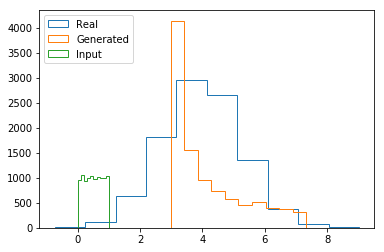

Stage 35, Epoch: 7000
Mean and Std of Real:  (4.0084698355901223, 1.2403809930593173)
Mean and Std of Gen:   (4.0266304, 1.2641779)


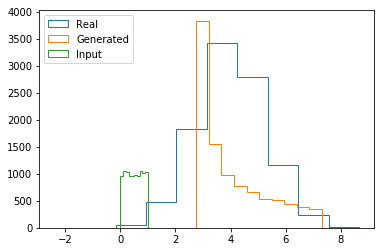

Stage 36, Epoch: 7200
Mean and Std of Real:  (3.9920468241172662, 1.2581168173898765)
Mean and Std of Gen:   (3.9889286, 1.3517388)


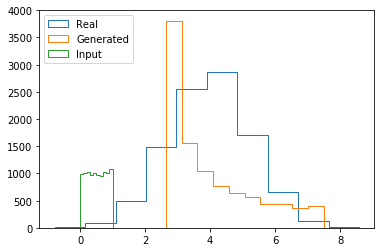

Stage 37, Epoch: 7400
Mean and Std of Real:  (3.9911384385142701, 1.2586845924238175)
Mean and Std of Gen:   (3.9644511, 1.2718338)


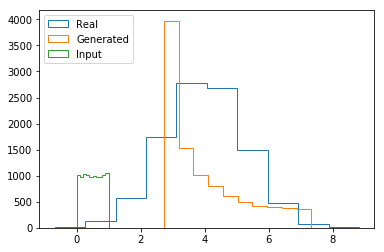

Stage 38, Epoch: 7600
Mean and Std of Real:  (3.9877258852260615, 1.2603411187495275)
Mean and Std of Gen:   (3.9396679, 1.3269893)


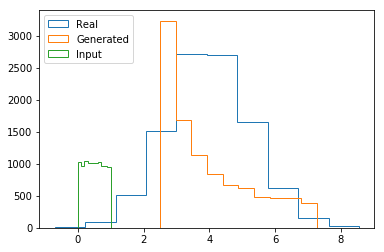

Stage 39, Epoch: 7800
Mean and Std of Real:  (3.9742582270672311, 1.2514866996497214)
Mean and Std of Gen:   (4.0293994, 0.99105)


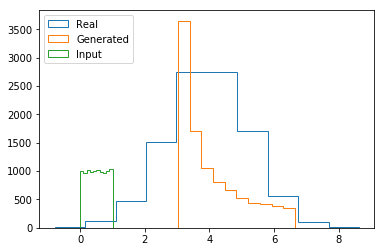

Stage 40, Epoch: 8000
Mean and Std of Real:  (3.9892023820480587, 1.230240254414964)
Mean and Std of Gen:   (3.8518298, 1.0632236)


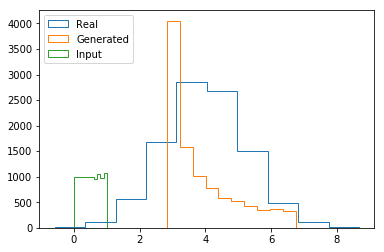

Stage 41, Epoch: 8200
Mean and Std of Real:  (4.0049334238284562, 1.247688873168816)
Mean and Std of Gen:   (3.9882753, 0.91720951)


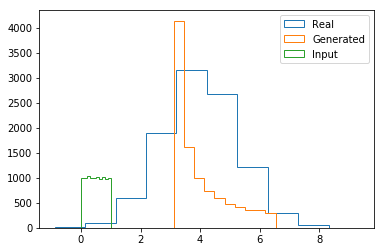

Stage 42, Epoch: 8400
Mean and Std of Real:  (4.0191971191008609, 1.2384537060433058)
Mean and Std of Gen:   (4.1727157, 1.0812926)


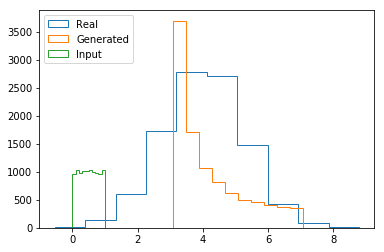

Stage 43, Epoch: 8600
Mean and Std of Real:  (4.0006741054945056, 1.2554223924764762)
Mean and Std of Gen:   (3.9817548, 1.2885141)


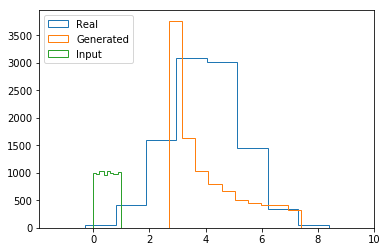

Stage 44, Epoch: 8800
Mean and Std of Real:  (3.983152327046747, 1.2461044357427931)
Mean and Std of Gen:   (4.0063915, 1.3563735)


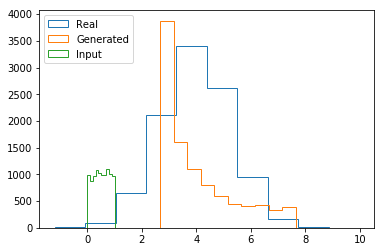

Stage 45, Epoch: 9000
Mean and Std of Real:  (3.9861172837147096, 1.259700469306501)
Mean and Std of Gen:   (4.0197487, 1.1239611)


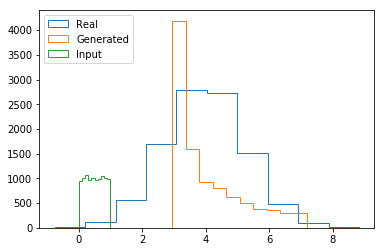

Stage 46, Epoch: 9200
Mean and Std of Real:  (4.0177862277149918, 1.2491987738379591)
Mean and Std of Gen:   (3.9535522, 1.1793066)


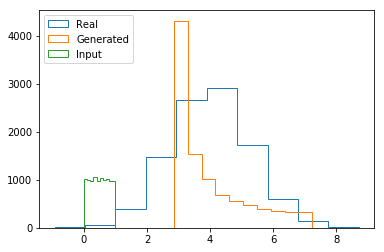

Stage 47, Epoch: 9400
Mean and Std of Real:  (3.9900566676776368, 1.2485082749060903)
Mean and Std of Gen:   (4.0308995, 1.3753705)


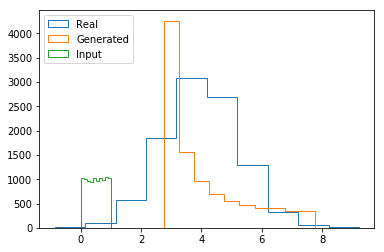

Stage 48, Epoch: 9600
Mean and Std of Real:  (4.0132083123265554, 1.2377608994080822)
Mean and Std of Gen:   (4.2234225, 1.2943835)


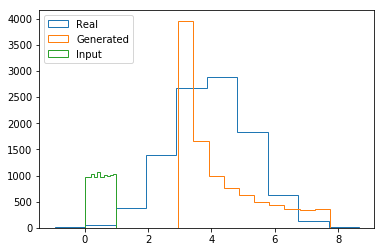

Stage 49, Epoch: 9800
Mean and Std of Real:  (3.9910485746159114, 1.2492895099394064)
Mean and Std of Gen:   (4.0167961, 1.1943727)


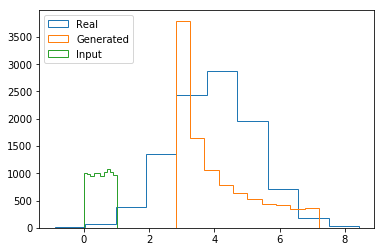

Stage 50, Epoch: 10000
Mean and Std of Real:  (4.002305479474356, 1.2556981751947536)
Mean and Std of Gen:   (3.9866364, 1.2898645)


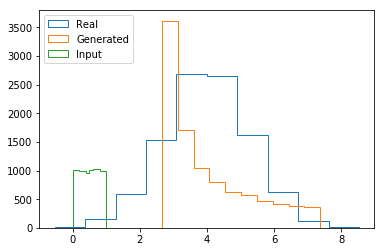

Stage 51, Epoch: 10200
Mean and Std of Real:  (3.9871267416793135, 1.2426910961379334)
Mean and Std of Gen:   (3.9809294, 1.2491946)


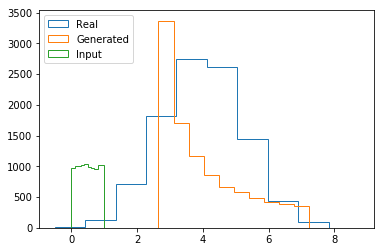

Stage 52, Epoch: 10400
Mean and Std of Real:  (3.9975309539816206, 1.2517270588818548)
Mean and Std of Gen:   (3.6901126, 1.2728918)


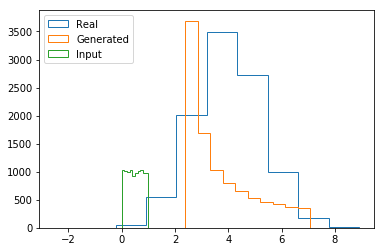

Stage 53, Epoch: 10600
Mean and Std of Real:  (3.9876173628033253, 1.2309239643315824)
Mean and Std of Gen:   (3.8773513, 1.2607653)


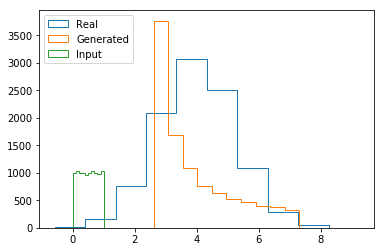

Stage 54, Epoch: 10800
Mean and Std of Real:  (3.9944971408202714, 1.2543353305181018)
Mean and Std of Gen:   (3.8609755, 1.2727494)


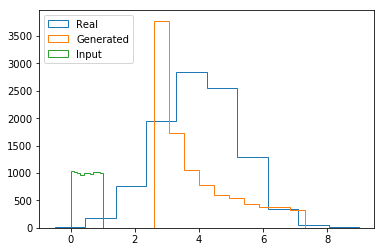

Stage 55, Epoch: 11000
Mean and Std of Real:  (4.0021751031182857, 1.2491057201505953)
Mean and Std of Gen:   (3.9662442, 1.2296176)


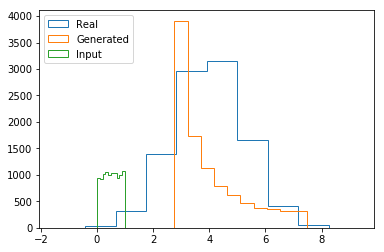

Stage 56, Epoch: 11200
Mean and Std of Real:  (3.9802987740369078, 1.2502576627286996)
Mean and Std of Gen:   (3.9980023, 1.2903192)


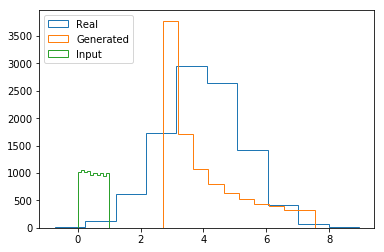

Stage 57, Epoch: 11400
Mean and Std of Real:  (4.0041518158505003, 1.2432219665599302)
Mean and Std of Gen:   (4.0028539, 1.3115726)


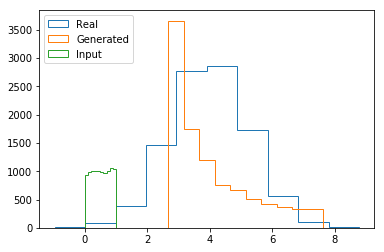

Stage 58, Epoch: 11600
Mean and Std of Real:  (4.0061170223103604, 1.2572473573474137)
Mean and Std of Gen:   (4.228303, 1.2420461)


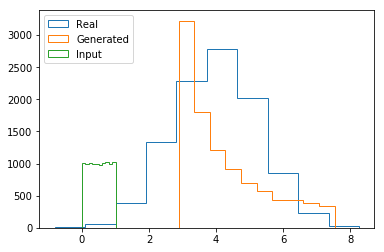

Stage 59, Epoch: 11800
Mean and Std of Real:  (4.0034891367498862, 1.2527350901660712)
Mean and Std of Gen:   (4.1548977, 1.2328827)


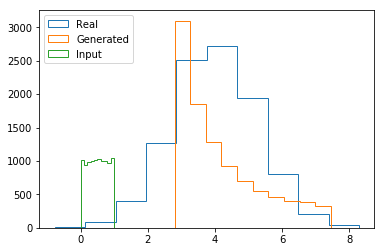

Stage 60, Epoch: 12000
Mean and Std of Real:  (4.0053461556100354, 1.2509104785623628)
Mean and Std of Gen:   (4.4483423, 1.1219879)


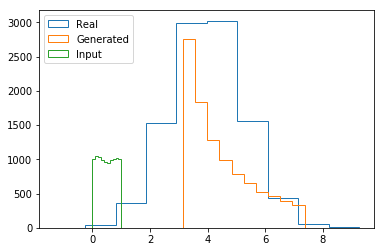

Stage 61, Epoch: 12200
Mean and Std of Real:  (4.0132392239790002, 1.2450213180438052)
Mean and Std of Gen:   (3.5668001, 1.2402748)


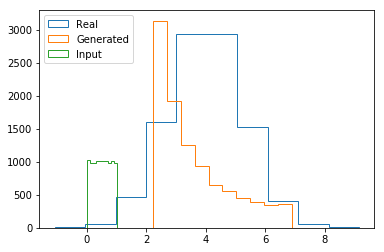

Stage 62, Epoch: 12400
Mean and Std of Real:  (3.9754093379742845, 1.2546914332956494)
Mean and Std of Gen:   (3.8703325, 1.3753468)


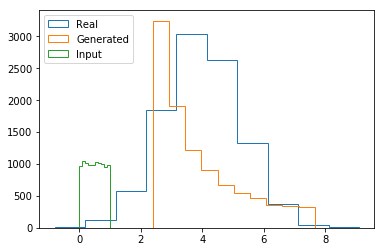

Stage 63, Epoch: 12600
Mean and Std of Real:  (4.012970065687699, 1.2419641386027771)
Mean and Std of Gen:   (3.9080796, 1.3859041)


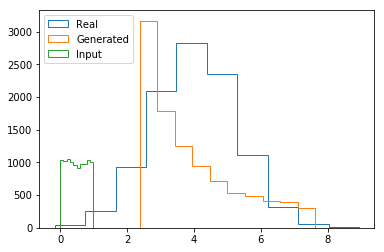

Stage 64, Epoch: 12800
Mean and Std of Real:  (4.0294922377896549, 1.2569809676657717)
Mean and Std of Gen:   (3.9948609, 1.2717104)


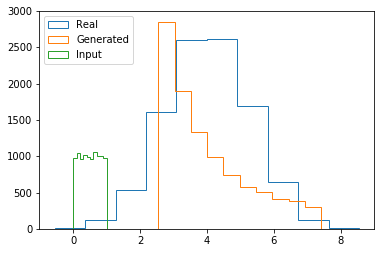

Stage 65, Epoch: 13000
Mean and Std of Real:  (3.9979794349199271, 1.2509124695363498)
Mean and Std of Gen:   (4.0996222, 1.27557)


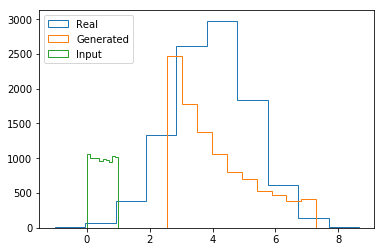

Stage 66, Epoch: 13200
Mean and Std of Real:  (4.0054092213691463, 1.2479843669231141)
Mean and Std of Gen:   (3.8264594, 1.4126691)


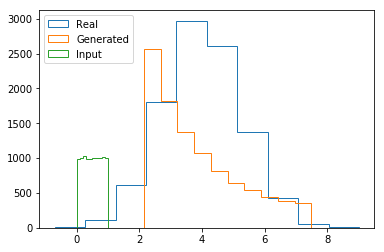

Stage 67, Epoch: 13400
Mean and Std of Real:  (4.0063916786184359, 1.2514082967826721)
Mean and Std of Gen:   (3.9635577, 1.2826846)


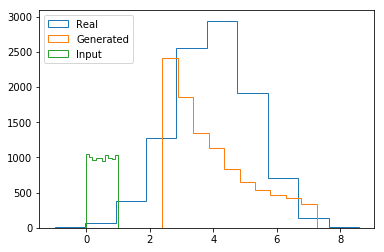

Stage 68, Epoch: 13600
Mean and Std of Real:  (3.9741459267180121, 1.2468637676397716)
Mean and Std of Gen:   (3.7365875, 1.1600802)


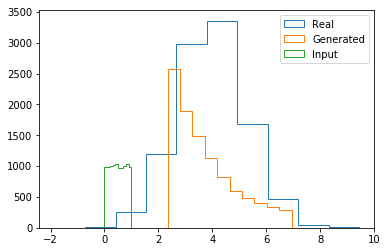

Stage 69, Epoch: 13800
Mean and Std of Real:  (3.9989271116946665, 1.2709652984213231)
Mean and Std of Gen:   (3.78563, 1.2087561)


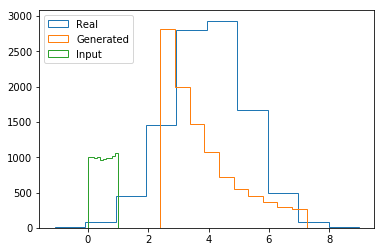

Stage 70, Epoch: 14000
Mean and Std of Real:  (4.0155938248810319, 1.2577982088213564)
Mean and Std of Gen:   (4.1494627, 1.2587428)


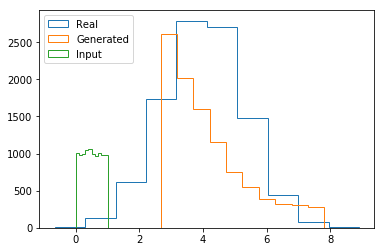

Stage 71, Epoch: 14200
Mean and Std of Real:  (4.0078702009163356, 1.2500992639185715)
Mean and Std of Gen:   (4.3229775, 1.1654043)


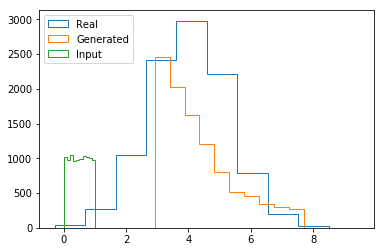

Stage 72, Epoch: 14400
Mean and Std of Real:  (4.014409999373667, 1.2628702344517964)
Mean and Std of Gen:   (4.0777044, 1.2460934)


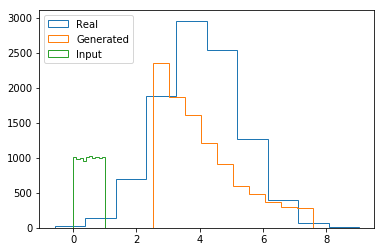

Stage 73, Epoch: 14600
Mean and Std of Real:  (3.9927669081560024, 1.24384945070105)
Mean and Std of Gen:   (3.8811419, 1.3209262)


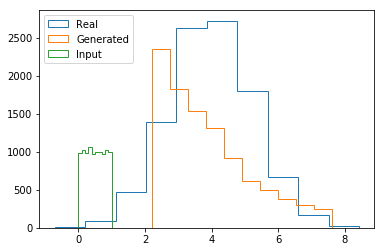

Stage 74, Epoch: 14800
Mean and Std of Real:  (3.985739893132703, 1.2516604313515745)
Mean and Std of Gen:   (3.7384243, 1.2191124)


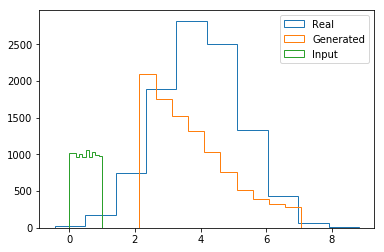

Stage 75, Epoch: 15000
Mean and Std of Real:  (4.0032224323464725, 1.2526218339132786)
Mean and Std of Gen:   (3.6499689, 1.2602109)


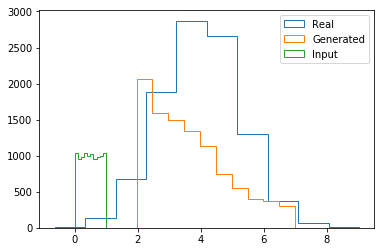

Stage 76, Epoch: 15200
Mean and Std of Real:  (4.0071493866504415, 1.2461078201808142)
Mean and Std of Gen:   (4.0369215, 1.2391168)


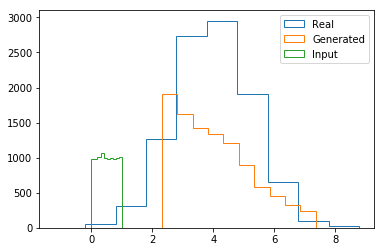

Stage 77, Epoch: 15400
Mean and Std of Real:  (4.0160291417541183, 1.246801923771728)
Mean and Std of Gen:   (4.5053635, 1.2487341)


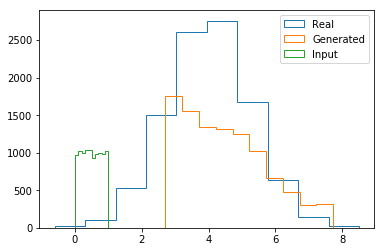

Stage 78, Epoch: 15600
Mean and Std of Real:  (3.9946546011431683, 1.2638491344968508)
Mean and Std of Gen:   (3.8633523, 1.2863398)


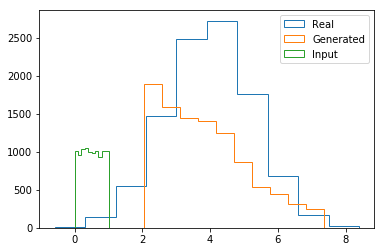

Stage 79, Epoch: 15800
Mean and Std of Real:  (3.9939375922274549, 1.2503148866078428)
Mean and Std of Gen:   (4.1865954, 1.2840726)


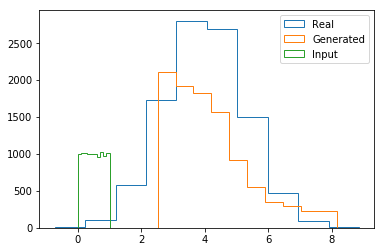

Stage 80, Epoch: 16000
Mean and Std of Real:  (4.0155625191272248, 1.2353522901486935)
Mean and Std of Gen:   (3.4865746, 1.2947124)


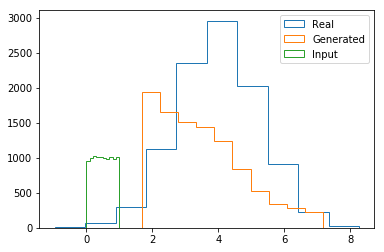

Stage 81, Epoch: 16200
Mean and Std of Real:  (4.0025992868464062, 1.2323729654522513)
Mean and Std of Gen:   (3.7434528, 1.2170986)


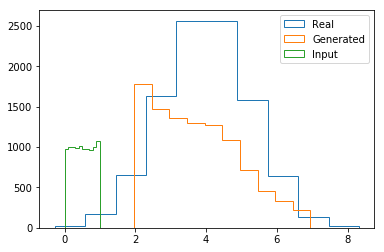

Stage 82, Epoch: 16400
Mean and Std of Real:  (4.0000690092964364, 1.2572759535445135)
Mean and Std of Gen:   (3.8093328, 1.2499019)


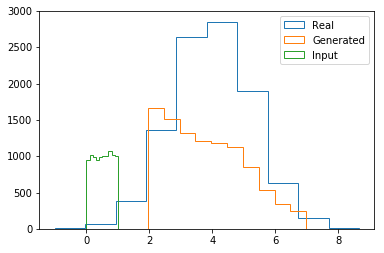

Stage 83, Epoch: 16600
Mean and Std of Real:  (3.9877265990042114, 1.2656027362875641)
Mean and Std of Gen:   (3.8541188, 1.1784711)


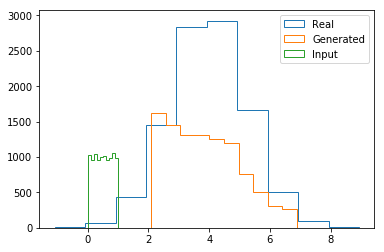

Stage 84, Epoch: 16800
Mean and Std of Real:  (3.989237167798156, 1.230820049211544)
Mean and Std of Gen:   (4.0825901, 1.3310432)


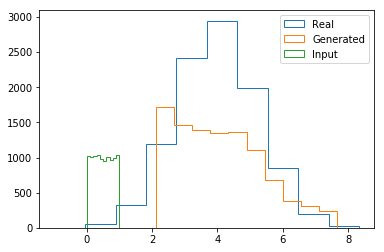

Stage 85, Epoch: 17000
Mean and Std of Real:  (3.9996301810947399, 1.2407845204842314)
Mean and Std of Gen:   (3.9695046, 1.2233813)


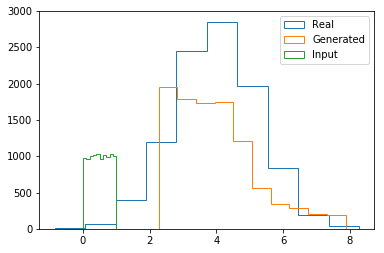

Stage 86, Epoch: 17200
Mean and Std of Real:  (3.9966411082794977, 1.2517413031255171)
Mean and Std of Gen:   (4.0033851, 1.2240133)


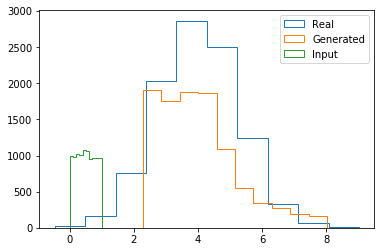

Stage 87, Epoch: 17400
Mean and Std of Real:  (3.9858959019067703, 1.2473671651179152)
Mean and Std of Gen:   (3.9059501, 1.3224828)


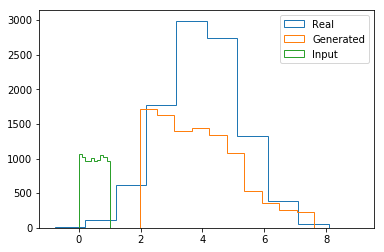

Stage 88, Epoch: 17600
Mean and Std of Real:  (4.0033875709621967, 1.2507152875720031)
Mean and Std of Gen:   (3.6721981, 1.4008178)


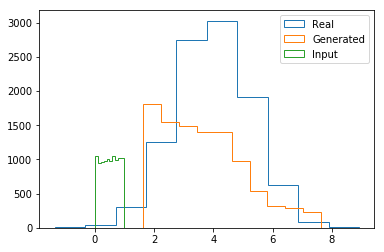

Stage 89, Epoch: 17800
Mean and Std of Real:  (3.9959141073485043, 1.2540194559599407)
Mean and Std of Gen:   (3.6773384, 1.3108349)


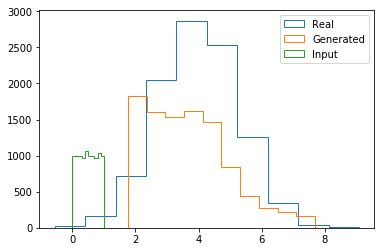

Stage 90, Epoch: 18000
Mean and Std of Real:  (3.9903737810753257, 1.2403968506307228)
Mean and Std of Gen:   (4.0056748, 1.3149935)


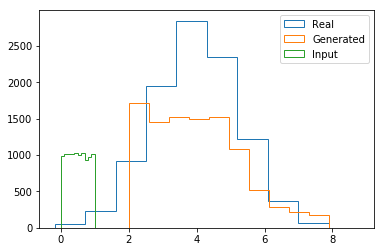

Stage 91, Epoch: 18200
Mean and Std of Real:  (3.9696827547191154, 1.2604546117858539)
Mean and Std of Gen:   (3.9809816, 1.3023869)


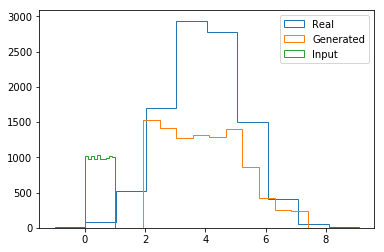

Stage 92, Epoch: 18400
Mean and Std of Real:  (3.9785600659578755, 1.2489168636766075)
Mean and Std of Gen:   (4.0519309, 1.2849188)


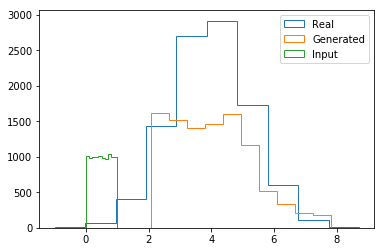

Stage 93, Epoch: 18600
Mean and Std of Real:  (3.9966999700403116, 1.2357651689937181)
Mean and Std of Gen:   (3.8370118, 1.2562003)


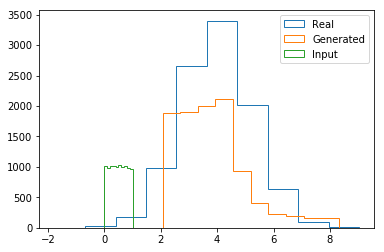

Stage 94, Epoch: 18800
Mean and Std of Real:  (3.9958139987968302, 1.2566052294439225)
Mean and Std of Gen:   (4.2328887, 1.2492096)


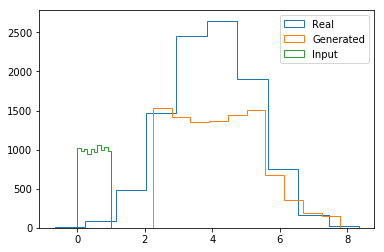

Stage 95, Epoch: 19000
Mean and Std of Real:  (4.0026489637575553, 1.2519080697255802)
Mean and Std of Gen:   (3.5989399, 1.3150201)


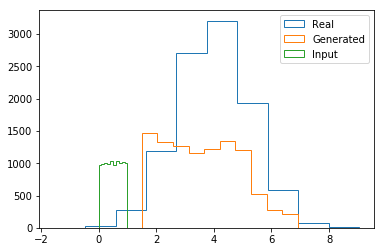

Stage 96, Epoch: 19200
Mean and Std of Real:  (3.9848014144237442, 1.2412784146860369)
Mean and Std of Gen:   (3.7428632, 1.2841772)


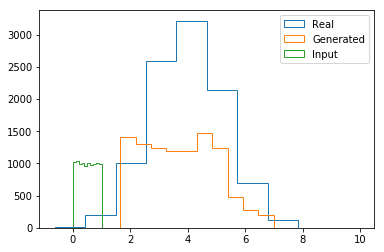

Stage 97, Epoch: 19400
Mean and Std of Real:  (4.0017806539125527, 1.2650012912229263)
Mean and Std of Gen:   (4.5784278, 1.1798497)


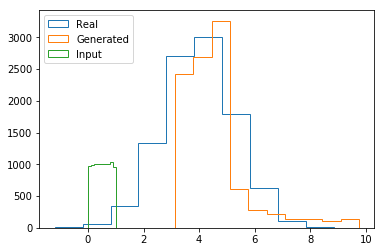

Stage 98, Epoch: 19600
Mean and Std of Real:  (4.009639114668472, 1.2527365833757917)
Mean and Std of Gen:   (4.1062932, 1.1648347)


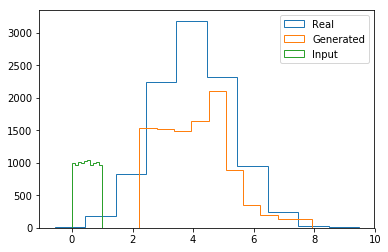

Stage 99, Epoch: 19800
Mean and Std of Real:  (4.0006287941562855, 1.2605965669005945)
Mean and Std of Gen:   (3.9896133, 1.2157532)


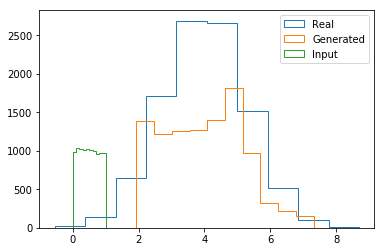

Stage 100, Epoch: 20000
Mean and Std of Real:  (4.0033607842939354, 1.251467549253535)
Mean and Std of Gen:   (3.6923962, 1.3250064)


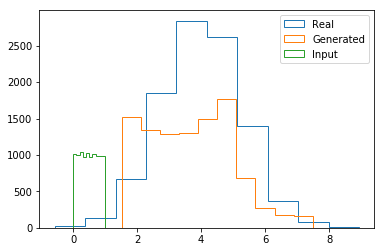

Stage 101, Epoch: 20200
Mean and Std of Real:  (4.013730490445707, 1.2530241695795259)
Mean and Std of Gen:   (4.1913996, 1.2713766)


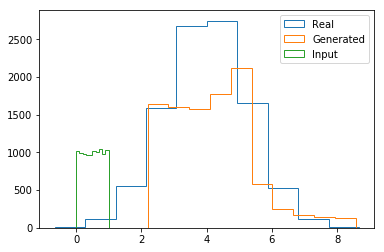

Stage 102, Epoch: 20400
Mean and Std of Real:  (3.9633096807783201, 1.2424528534742003)
Mean and Std of Gen:   (4.0270629, 1.3134112)


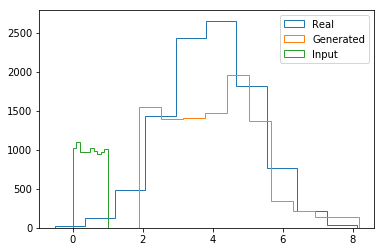

Stage 103, Epoch: 20600
Mean and Std of Real:  (4.0048290889215536, 1.2474635918768819)
Mean and Std of Gen:   (3.8694685, 1.2965245)


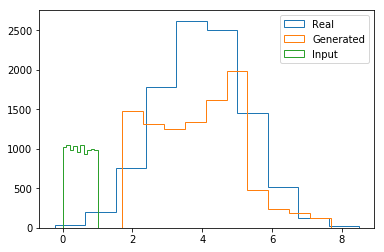

Stage 104, Epoch: 20800
Mean and Std of Real:  (4.0057998509891295, 1.2419044232054413)
Mean and Std of Gen:   (4.0216336, 1.2581739)


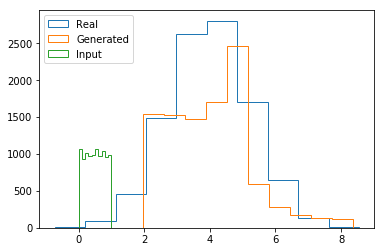

Stage 105, Epoch: 21000
Mean and Std of Real:  (4.0058031936126541, 1.2459736836353617)
Mean and Std of Gen:   (4.0561738, 1.1750535)


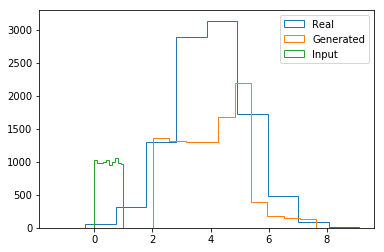

Stage 106, Epoch: 21200
Mean and Std of Real:  (3.9922797755436492, 1.2680414112728873)
Mean and Std of Gen:   (3.8492262, 1.2197031)


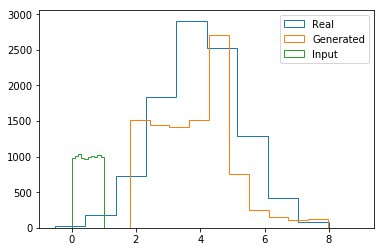

Stage 107, Epoch: 21400
Mean and Std of Real:  (4.0169370828024036, 1.2416720168190272)
Mean and Std of Gen:   (3.9622624, 1.2729181)


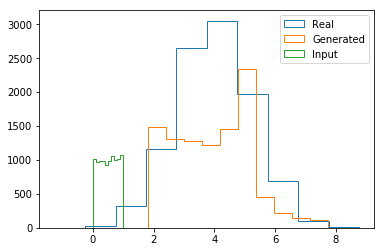

Stage 108, Epoch: 21600
Mean and Std of Real:  (4.0024254594995972, 1.2384941853551859)
Mean and Std of Gen:   (4.0668945, 1.2844696)


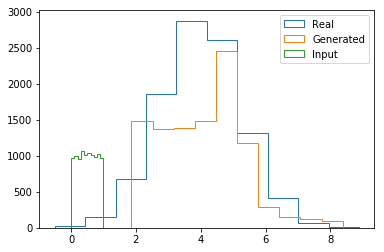

Stage 109, Epoch: 21800
Mean and Std of Real:  (4.0078954248571499, 1.2644764455815289)
Mean and Std of Gen:   (3.922785, 1.2280592)


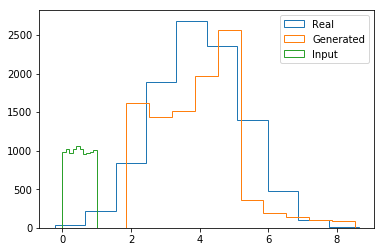

Stage 110, Epoch: 22000
Mean and Std of Real:  (4.0030233940068358, 1.2579768038838723)
Mean and Std of Gen:   (3.8390372, 1.2827796)


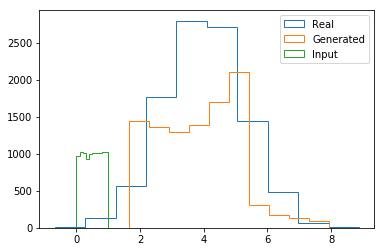

Stage 111, Epoch: 22200
Mean and Std of Real:  (3.9876162380989189, 1.2437570738173696)
Mean and Std of Gen:   (4.0552611, 1.2271117)


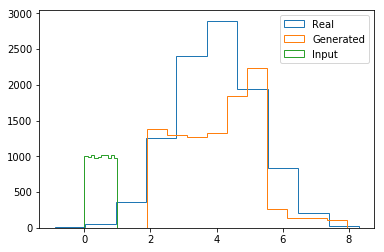

Stage 112, Epoch: 22400
Mean and Std of Real:  (4.0070371822039208, 1.2513548027967427)
Mean and Std of Gen:   (4.3173265, 1.2249081)


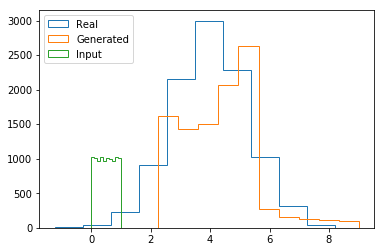

Stage 113, Epoch: 22600
Mean and Std of Real:  (4.0004729078837773, 1.2573788987381287)
Mean and Std of Gen:   (3.9623129, 1.2807109)


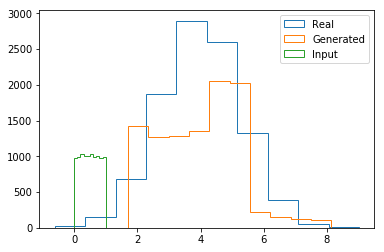

Stage 114, Epoch: 22800
Mean and Std of Real:  (3.9793995532310333, 1.244316772108244)
Mean and Std of Gen:   (4.058146, 1.2076145)


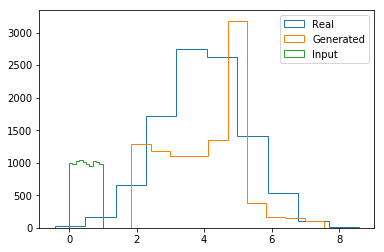

Stage 115, Epoch: 23000
Mean and Std of Real:  (4.0087034499590777, 1.261279114514352)
Mean and Std of Gen:   (3.9949598, 1.2122036)


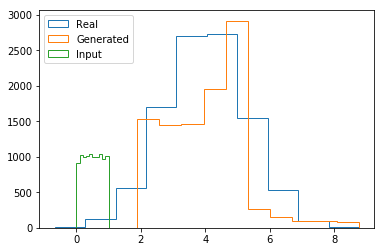

Stage 116, Epoch: 23200
Mean and Std of Real:  (4.0115960930498256, 1.2637939412519437)
Mean and Std of Gen:   (3.9872031, 1.2381506)


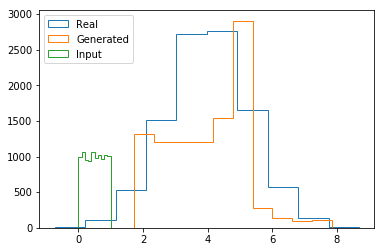

Stage 117, Epoch: 23400
Mean and Std of Real:  (3.9961017131204062, 1.2446585228265628)
Mean and Std of Gen:   (3.8426692, 1.3271594)


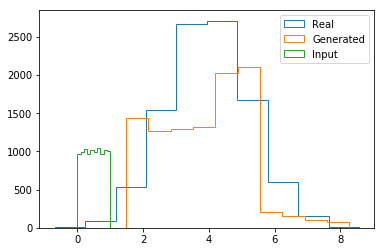

Stage 118, Epoch: 23600
Mean and Std of Real:  (3.9844939332681983, 1.2448958941162025)
Mean and Std of Gen:   (3.8085411, 1.3137503)


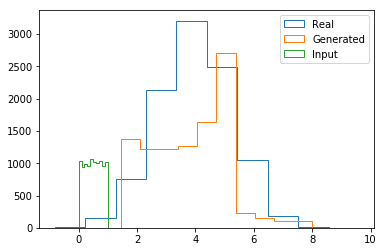

Stage 119, Epoch: 23800
Mean and Std of Real:  (4.020184718856914, 1.2510976535664937)
Mean and Std of Gen:   (4.0200176, 1.1694331)


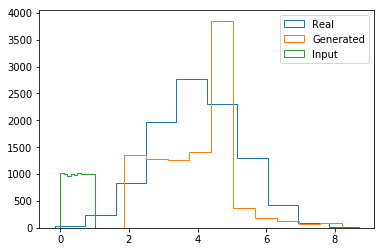

Stage 120, Epoch: 24000
Mean and Std of Real:  (3.9926014542968349, 1.2509235648022574)
Mean and Std of Gen:   (4.1130962, 1.1838778)


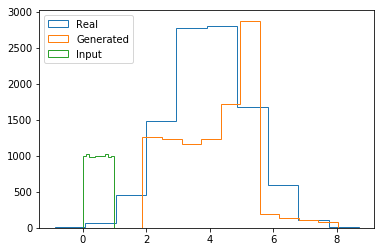

Stage 121, Epoch: 24200
Mean and Std of Real:  (4.0267934448667564, 1.2453966257424922)
Mean and Std of Gen:   (3.9450078, 1.2692645)


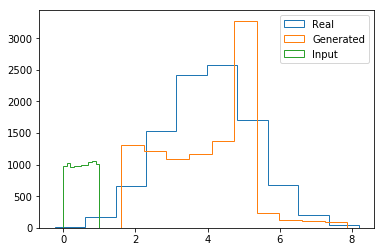

Stage 122, Epoch: 24400
Mean and Std of Real:  (3.9909823320396915, 1.255063875088597)
Mean and Std of Gen:   (4.0650167, 1.1635852)


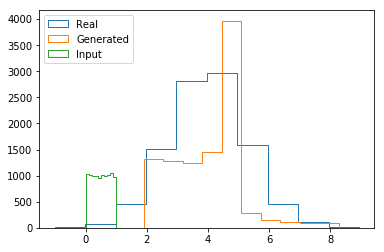

Stage 123, Epoch: 24600
Mean and Std of Real:  (3.9738120823338359, 1.2626401177187692)
Mean and Std of Gen:   (3.9402082, 1.3254541)


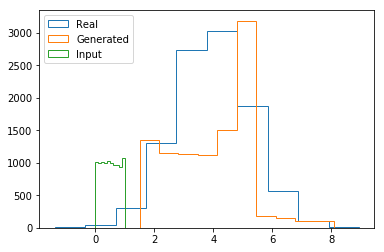

Stage 124, Epoch: 24800
Mean and Std of Real:  (3.9834824293369544, 1.2520335638703217)
Mean and Std of Gen:   (4.023262, 1.3029543)


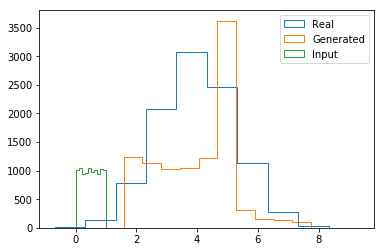

Stage 125, Epoch: 25000
Mean and Std of Real:  (3.9890776079432237, 1.2565447530897893)
Mean and Std of Gen:   (3.9632797, 1.274241)


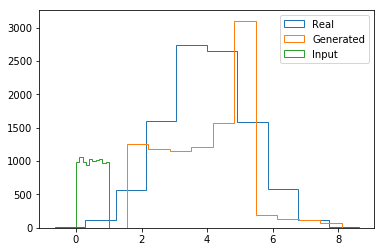

Stage 126, Epoch: 25200
Mean and Std of Real:  (3.970470536917579, 1.2482703408679334)
Mean and Std of Gen:   (4.1727729, 1.1848722)


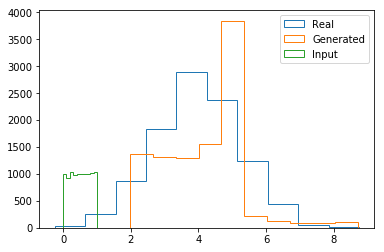

Stage 127, Epoch: 25400
Mean and Std of Real:  (4.01155913525879, 1.25001186248957)
Mean and Std of Gen:   (3.8938403, 1.3517101)


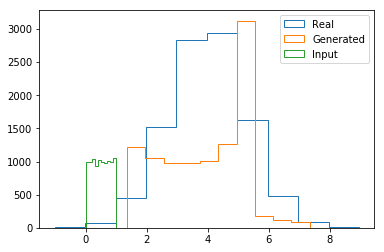

Stage 128, Epoch: 25600
Mean and Std of Real:  (3.986530504977869, 1.2609683066889863)
Mean and Std of Gen:   (4.0000906, 1.1784052)


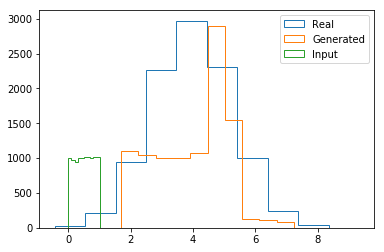

Stage 129, Epoch: 25800
Mean and Std of Real:  (4.0033275611800612, 1.2287813510432246)
Mean and Std of Gen:   (4.2215853, 1.2267323)


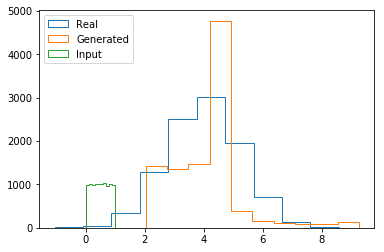

Stage 130, Epoch: 26000
Mean and Std of Real:  (3.9999506013120363, 1.2591792487335136)
Mean and Std of Gen:   (4.1154461, 1.1176214)


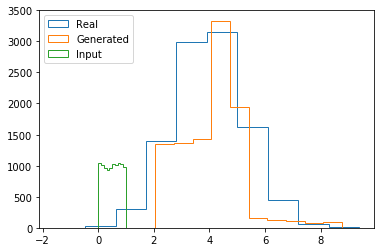

Stage 131, Epoch: 26200
Mean and Std of Real:  (4.0033684557754041, 1.2480060370675232)
Mean and Std of Gen:   (3.8571632, 1.3271208)


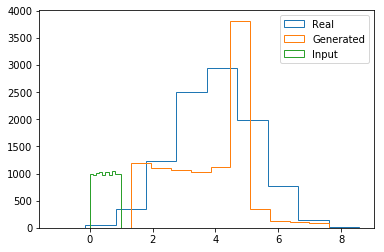

Stage 132, Epoch: 26400
Mean and Std of Real:  (4.0106967519647316, 1.2577705208425147)
Mean and Std of Gen:   (3.8929024, 1.2580755)


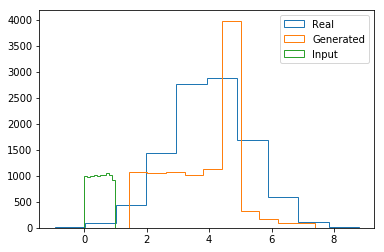

Stage 133, Epoch: 26600
Mean and Std of Real:  (3.9927315793385825, 1.2484178896920224)
Mean and Std of Gen:   (4.1738586, 1.241547)


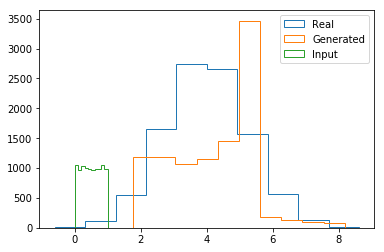

Stage 134, Epoch: 26800
Mean and Std of Real:  (3.9895736883147417, 1.2402081526568636)
Mean and Std of Gen:   (4.077024, 1.2957861)


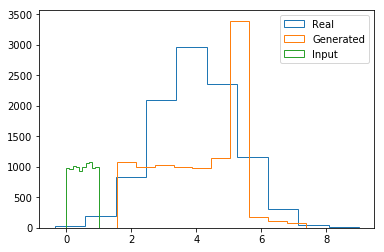

Stage 135, Epoch: 27000
Mean and Std of Real:  (3.9901675633874167, 1.2576240373634502)
Mean and Std of Gen:   (4.0860586, 1.2450526)


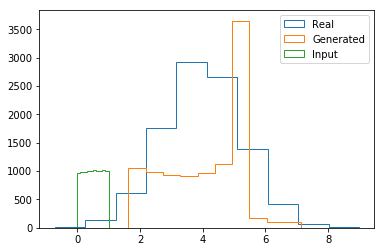

Stage 136, Epoch: 27200
Mean and Std of Real:  (4.0037504460833544, 1.249853094024892)
Mean and Std of Gen:   (3.899193, 1.2319195)


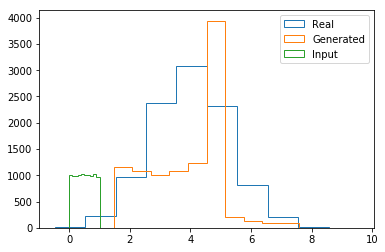

Stage 137, Epoch: 27400
Mean and Std of Real:  (4.010759817603855, 1.2481524511396047)
Mean and Std of Gen:   (4.0977354, 1.2389115)


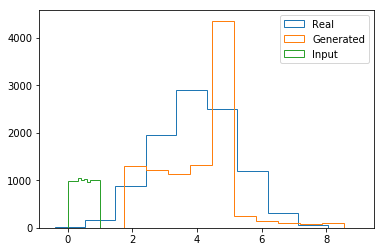

Stage 138, Epoch: 27600
Mean and Std of Real:  (3.9969408258925787, 1.2593041706117825)
Mean and Std of Gen:   (3.8276992, 1.1603907)


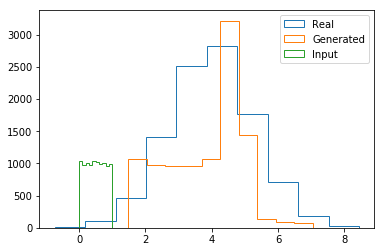

Stage 139, Epoch: 27800
Mean and Std of Real:  (4.0109775269700414, 1.2524801708259701)
Mean and Std of Gen:   (4.0941396, 1.2946756)


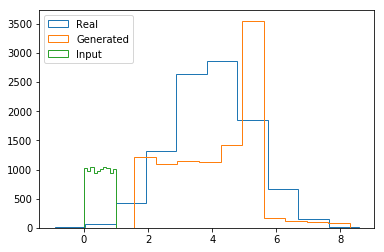

Stage 140, Epoch: 28000
Mean and Std of Real:  (3.9948266144470761, 1.2388090133679681)
Mean and Std of Gen:   (4.4266958, 1.1184906)


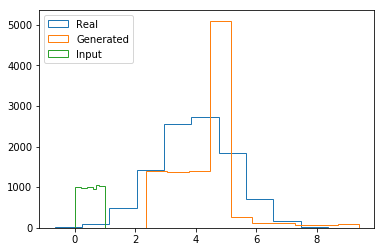

Stage 141, Epoch: 28200
Mean and Std of Real:  (4.001131235868133, 1.2542262551233294)
Mean and Std of Gen:   (4.0864224, 1.303691)


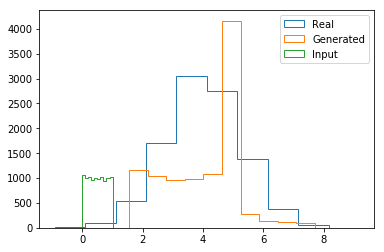

Stage 142, Epoch: 28400
Mean and Std of Real:  (3.9978216988329325, 1.2595996147286115)
Mean and Std of Gen:   (3.8006067, 1.2507126)


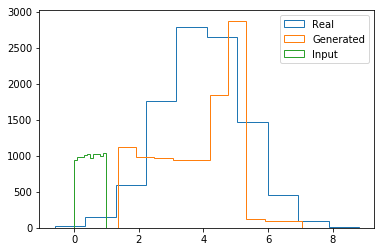

Stage 143, Epoch: 28600
Mean and Std of Real:  (3.9999772426125868, 1.2495182263600169)
Mean and Std of Gen:   (4.121665, 1.1636475)


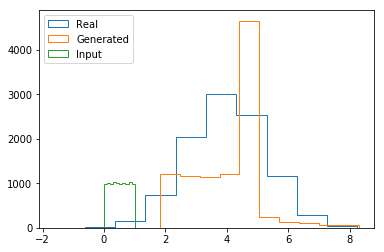

Stage 144, Epoch: 28800
Mean and Std of Real:  (3.9876735323854082, 1.2416229160794419)
Mean and Std of Gen:   (4.1109562, 1.2111005)


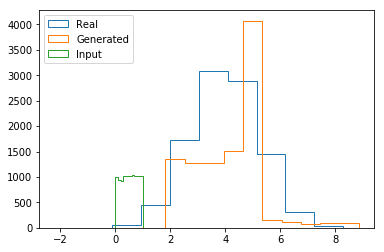

Stage 145, Epoch: 29000
Mean and Std of Real:  (3.9950279037155014, 1.2434695933742761)
Mean and Std of Gen:   (3.9841106, 1.2301083)


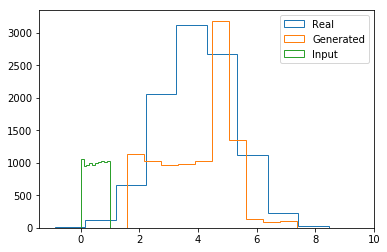

Stage 146, Epoch: 29200
Mean and Std of Real:  (4.0128701458065681, 1.2677199538821107)
Mean and Std of Gen:   (3.9638243, 1.2399995)


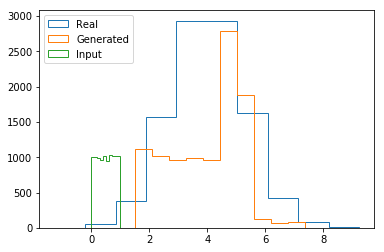

Stage 147, Epoch: 29400
Mean and Std of Real:  (3.9869814769671064, 1.245046448513367)
Mean and Std of Gen:   (3.7715282, 1.3088604)


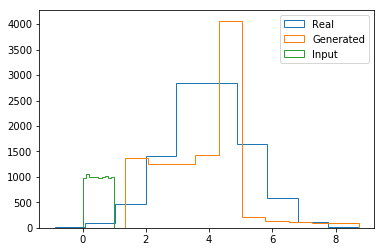

Stage 148, Epoch: 29600
Mean and Std of Real:  (3.9942887761960408, 1.2664013803626968)
Mean and Std of Gen:   (3.9327891, 1.2605175)


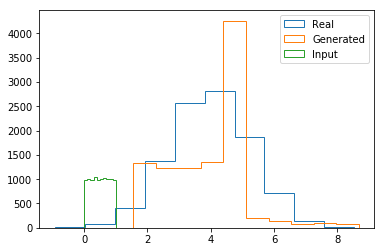

Stage 149, Epoch: 29800
Mean and Std of Real:  (3.9935426079067802, 1.2555559030712491)
Mean and Std of Gen:   (3.9679379, 1.3174438)


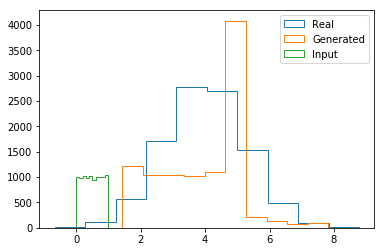

Stage 150, Epoch: 30000
Mean and Std of Real:  (4.0016855550816919, 1.2584672319263881)
Mean and Std of Gen:   (3.7607536, 1.2958187)


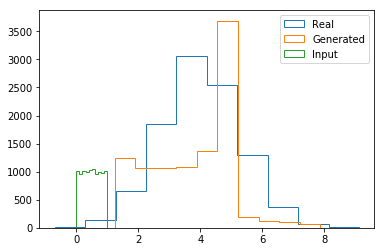

Stage 151, Epoch: 30200
Mean and Std of Real:  (4.0095751440157361, 1.2388152717762086)
Mean and Std of Gen:   (3.8909194, 1.2924767)


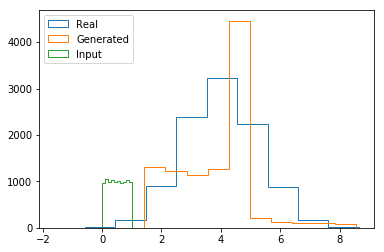

Stage 152, Epoch: 30400
Mean and Std of Real:  (4.0169881276825778, 1.254324496344305)
Mean and Std of Gen:   (4.1332417, 1.2272701)


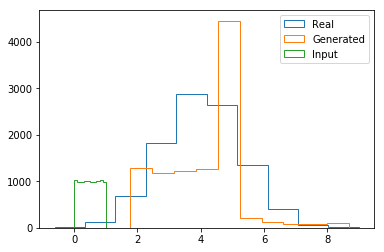

Stage 153, Epoch: 30600
Mean and Std of Real:  (4.0101856796381394, 1.2482191976798251)
Mean and Std of Gen:   (3.888618, 1.2342898)


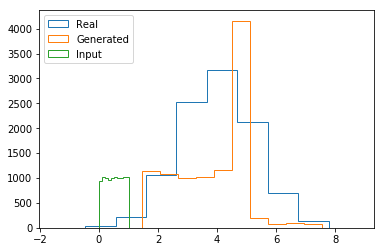

Stage 154, Epoch: 30800
Mean and Std of Real:  (4.008579260511147, 1.2525182689509875)
Mean and Std of Gen:   (4.0209374, 1.2817241)


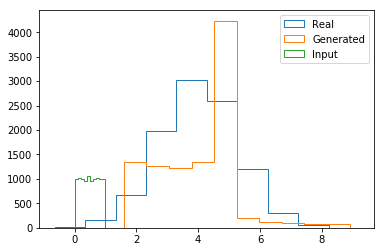

Stage 155, Epoch: 31000
Mean and Std of Real:  (4.0000184523882334, 1.2375688953575223)
Mean and Std of Gen:   (4.0231109, 1.2729564)


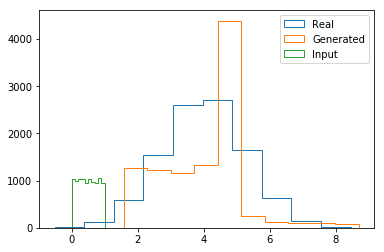

Stage 156, Epoch: 31200
Mean and Std of Real:  (4.0006000554465766, 1.2445041780934114)
Mean and Std of Gen:   (4.0162463, 1.2664419)


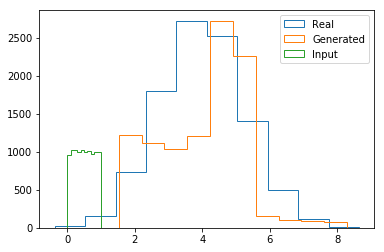

Stage 157, Epoch: 31400
Mean and Std of Real:  (4.0108029540533625, 1.2452790733994901)
Mean and Std of Gen:   (3.6736741, 1.2843969)


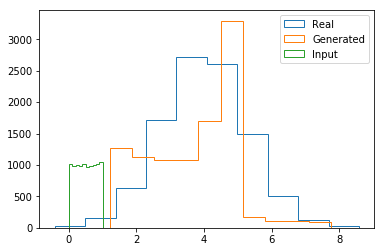

Stage 158, Epoch: 31600
Mean and Std of Real:  (3.9901257321906489, 1.2523216578052565)
Mean and Std of Gen:   (3.8616664, 1.2991915)


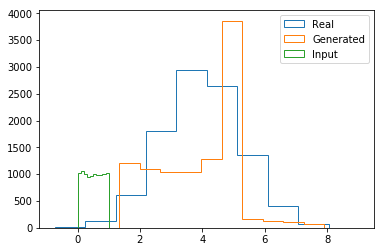

Stage 159, Epoch: 31800
Mean and Std of Real:  (4.0087349244673085, 1.2378679342585124)
Mean and Std of Gen:   (4.0886331, 1.1426555)


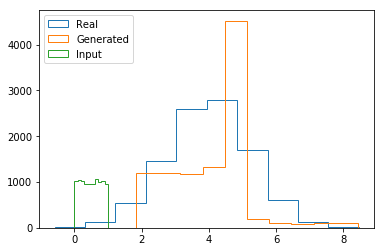

Stage 160, Epoch: 32000
Mean and Std of Real:  (4.0057456860106964, 1.2546409630598365)
Mean and Std of Gen:   (3.9422116, 1.3102031)


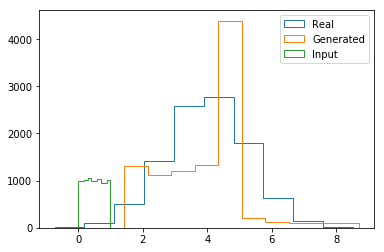

Stage 161, Epoch: 32200
Mean and Std of Real:  (4.0090406441813187, 1.2543970486870122)
Mean and Std of Gen:   (3.8715594, 1.2295084)


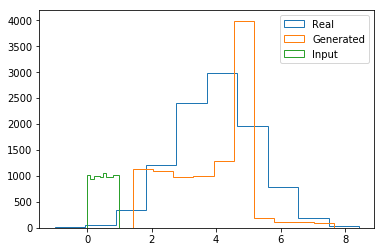

Stage 162, Epoch: 32400
Mean and Std of Real:  (4.0112990613648911, 1.2507958032576927)
Mean and Std of Gen:   (3.7956226, 1.3093905)


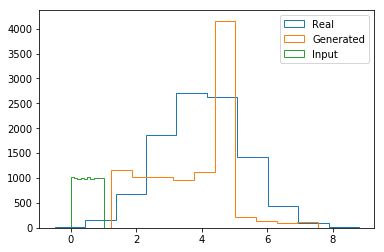

Stage 163, Epoch: 32600
Mean and Std of Real:  (4.0041056656223573, 1.2708337832693388)
Mean and Std of Gen:   (3.897634, 1.2522454)


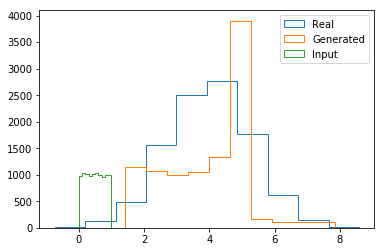

Stage 164, Epoch: 32800
Mean and Std of Real:  (4.0055554321754459, 1.2429475534630114)
Mean and Std of Gen:   (4.3006239, 1.1151383)


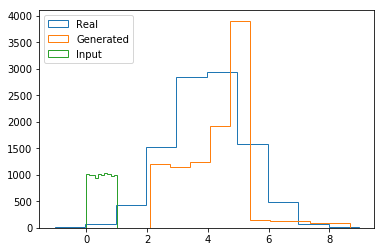

Stage 165, Epoch: 33000
Mean and Std of Real:  (4.0062121405784241, 1.2600928450937834)
Mean and Std of Gen:   (4.0010729, 1.2273318)


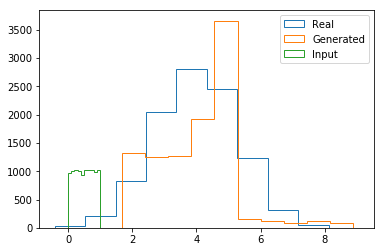

Stage 166, Epoch: 33200
Mean and Std of Real:  (4.0063537967514558, 1.2458476156352918)
Mean and Std of Gen:   (3.9741714, 1.3302754)


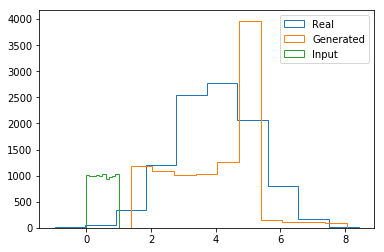

Stage 167, Epoch: 33400
Mean and Std of Real:  (4.0221426208932662, 1.2436414035502745)
Mean and Std of Gen:   (4.0208192, 1.2795936)


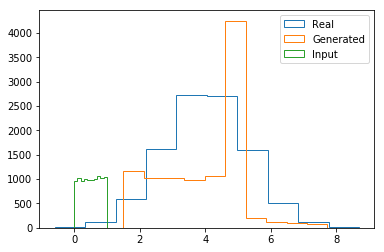

Stage 168, Epoch: 33600
Mean and Std of Real:  (4.001825077373157, 1.2634706933728139)
Mean and Std of Gen:   (3.8038638, 1.3048178)


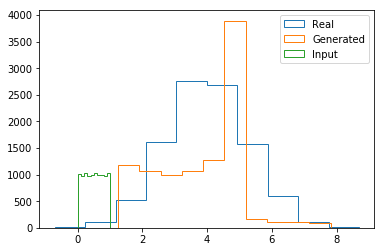

Stage 169, Epoch: 33800
Mean and Std of Real:  (3.9985944149994967, 1.2592377061443978)
Mean and Std of Gen:   (4.285821, 1.1221613)


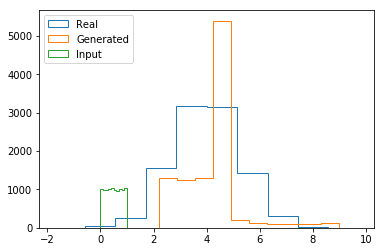

Stage 170, Epoch: 34000
Mean and Std of Real:  (3.9930266247340698, 1.271868504256261)
Mean and Std of Gen:   (4.0772471, 1.2817816)


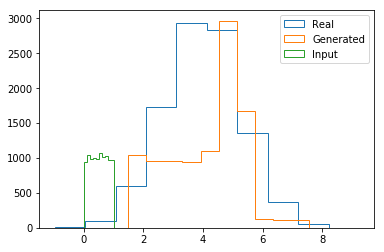

Stage 171, Epoch: 34200
Mean and Std of Real:  (4.0136390288679831, 1.2304463486447137)
Mean and Std of Gen:   (4.1531477, 1.1967121)


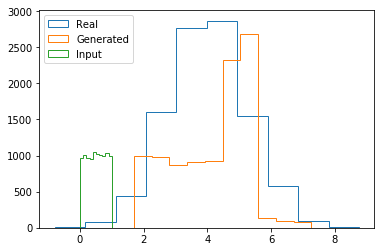

Stage 172, Epoch: 34400
Mean and Std of Real:  (4.0001835887176309, 1.2591635714176599)
Mean and Std of Gen:   (4.1529732, 1.1167967)


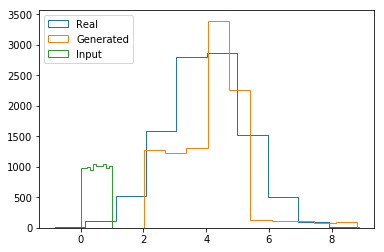

Stage 173, Epoch: 34600
Mean and Std of Real:  (4.0127613416617107, 1.2687361140223217)
Mean and Std of Gen:   (4.0747018, 1.255385)


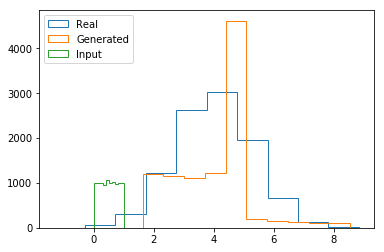

Stage 174, Epoch: 34800
Mean and Std of Real:  (4.0201602756053694, 1.2541524829294464)
Mean and Std of Gen:   (3.913764, 1.2668384)


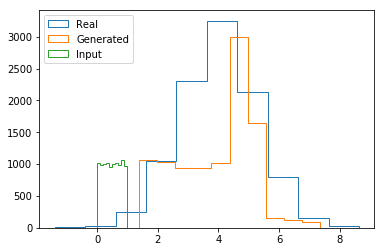

Stage 175, Epoch: 35000
Mean and Std of Real:  (3.9953342484247019, 1.2507812418848521)
Mean and Std of Gen:   (3.7919133, 1.3349468)


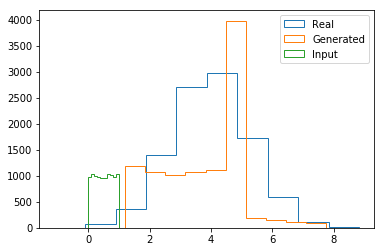

Stage 176, Epoch: 35200
Mean and Std of Real:  (4.0100692320306184, 1.2378580513458275)
Mean and Std of Gen:   (4.1460619, 1.224679)


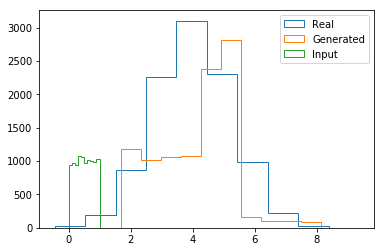

Stage 177, Epoch: 35400
Mean and Std of Real:  (4.006248988568383, 1.2447943808857527)
Mean and Std of Gen:   (4.3496561, 1.1862577)


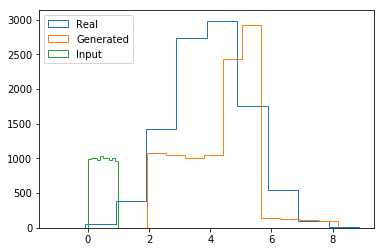

Stage 178, Epoch: 35600
Mean and Std of Real:  (4.0053326297542684, 1.2502087679612208)
Mean and Std of Gen:   (3.7483099, 1.3071924)


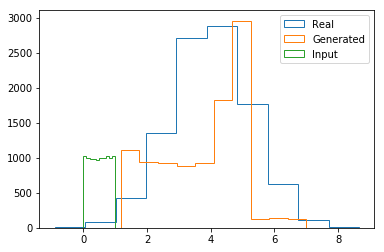

Stage 179, Epoch: 35800
Mean and Std of Real:  (3.9951066424529889, 1.2550224252356963)
Mean and Std of Gen:   (4.1806803, 1.2226461)


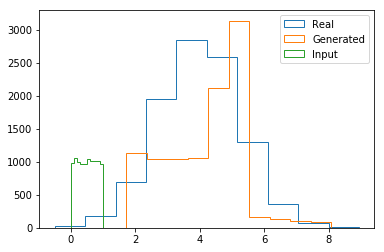

Stage 180, Epoch: 36000
Mean and Std of Real:  (3.9897975030227775, 1.2444140041764042)
Mean and Std of Gen:   (4.339973, 1.146418)


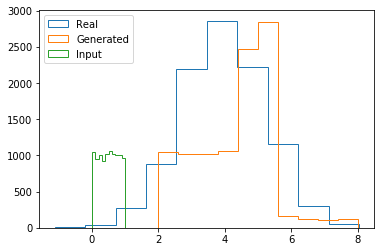

Stage 181, Epoch: 36200
Mean and Std of Real:  (4.0057032652579601, 1.234238890110182)
Mean and Std of Gen:   (3.7858899, 1.3550068)


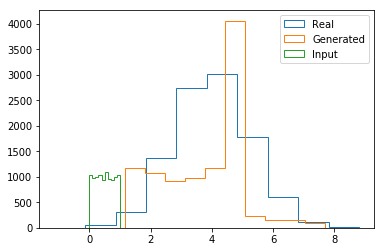

Stage 182, Epoch: 36400
Mean and Std of Real:  (3.9796172665833311, 1.2586555701762023)
Mean and Std of Gen:   (3.9812427, 1.2463131)


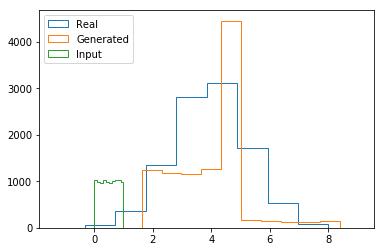

Stage 183, Epoch: 36600
Mean and Std of Real:  (3.9899242165223696, 1.2401468957120545)
Mean and Std of Gen:   (4.0819583, 1.2422677)


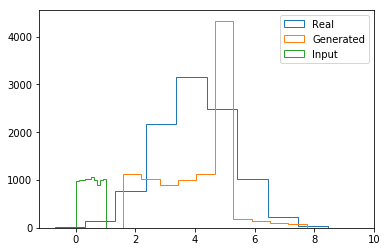

Stage 184, Epoch: 36800
Mean and Std of Real:  (3.9939523398392778, 1.2675571195236173)
Mean and Std of Gen:   (3.939755, 1.2071626)


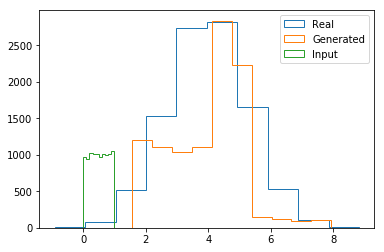

Stage 185, Epoch: 37000
Mean and Std of Real:  (4.0065931269829145, 1.2294543487997589)
Mean and Std of Gen:   (3.9671125, 1.2040733)


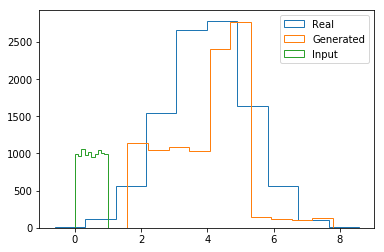

Stage 186, Epoch: 37200
Mean and Std of Real:  (4.0130031365508589, 1.2387925944284865)
Mean and Std of Gen:   (3.8114324, 1.2687619)


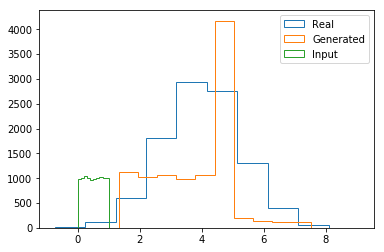

Stage 187, Epoch: 37400
Mean and Std of Real:  (4.0034930538804856, 1.2547929081071043)
Mean and Std of Gen:   (3.82125, 1.4257705)


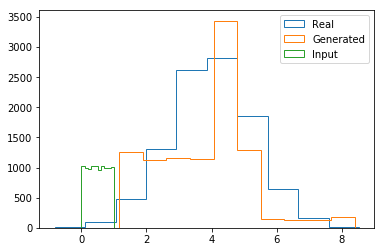

Stage 188, Epoch: 37600
Mean and Std of Real:  (4.005926127804905, 1.255696492396112)
Mean and Std of Gen:   (3.9729648, 1.2636337)


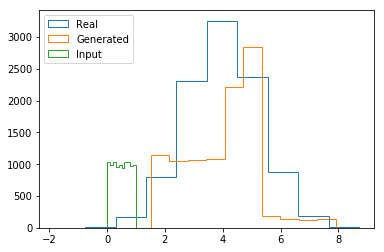

Stage 189, Epoch: 37800
Mean and Std of Real:  (4.0019115025807777, 1.2572478096255495)
Mean and Std of Gen:   (3.9272289, 1.2726212)


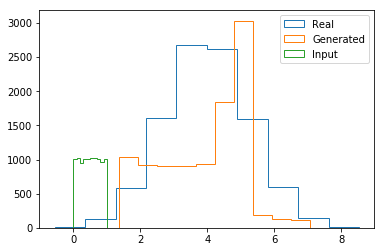

Stage 190, Epoch: 38000
Mean and Std of Real:  (4.0115838381643494, 1.2494982507459307)
Mean and Std of Gen:   (3.7797062, 1.2350777)


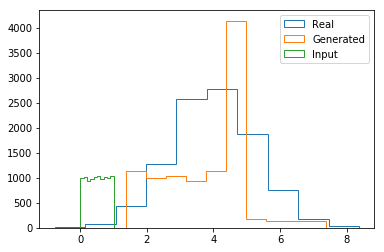

Stage 191, Epoch: 38200
Mean and Std of Real:  (4.0006539666059293, 1.2343921138025786)
Mean and Std of Gen:   (3.8607757, 1.2815078)


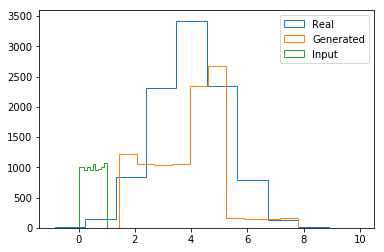

Stage 192, Epoch: 38400
Mean and Std of Real:  (3.983293652731084, 1.2373711648848371)
Mean and Std of Gen:   (4.1398067, 1.2206506)


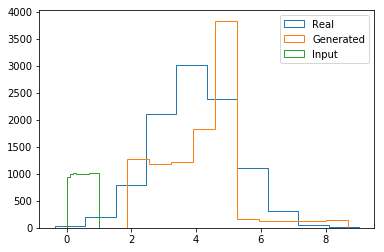

Stage 193, Epoch: 38600
Mean and Std of Real:  (3.9931267966061843, 1.2300462803323646)
Mean and Std of Gen:   (4.1527719, 1.219615)


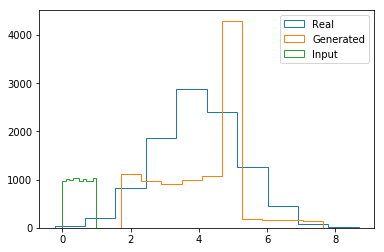

Stage 194, Epoch: 38800
Mean and Std of Real:  (4.007812725018014, 1.2546338544046725)
Mean and Std of Gen:   (3.9320433, 1.2930695)


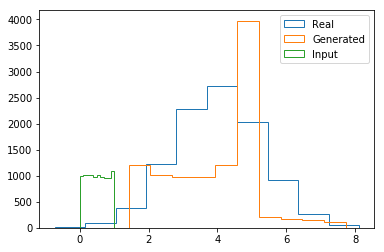

Stage 195, Epoch: 39000
Mean and Std of Real:  (4.0014192803516568, 1.2592573129698601)
Mean and Std of Gen:   (3.8818586, 1.2916002)


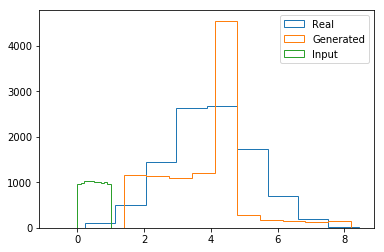

Stage 196, Epoch: 39200
Mean and Std of Real:  (3.9927549074343873, 1.2429204012266459)
Mean and Std of Gen:   (4.0975623, 1.2444923)


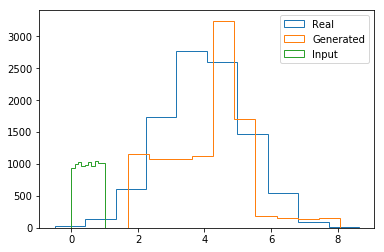

Stage 197, Epoch: 39400
Mean and Std of Real:  (3.9968187745573429, 1.2416210742341802)
Mean and Std of Gen:   (3.9381163, 1.2903701)


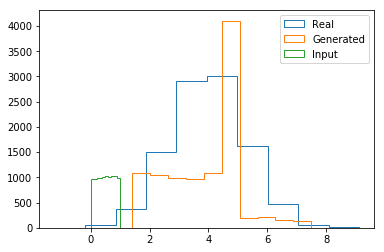

Stage 198, Epoch: 39600
Mean and Std of Real:  (3.9895307671861859, 1.2485163682135501)
Mean and Std of Gen:   (3.6175113, 1.3284185)


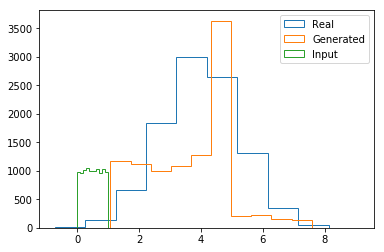

Stage 199, Epoch: 39800
Mean and Std of Real:  (4.0033982914925321, 1.2683374137154975)
Mean and Std of Gen:   (4.0724082, 1.2049906)


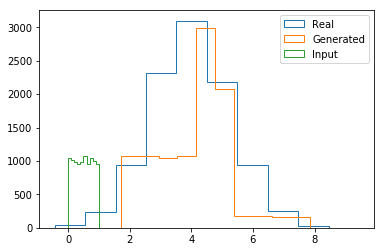

In [33]:
main()